In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from netCDF4 import Dataset,date2num, num2date
import os
import netCDF4
# import cartopy.crs as ccrs
# from scipy.stats import linregress
# from sklearn.linear_model import QuantileRegressor, Ridge
# from scipy.stats import pearsonr
import matplotlib.patches as mpatches
%matplotlib inline

# import statsmodels.api as sm
# import statsmodels as sm

In [2]:
import sys

sys.path.append('/scistor/ivm/the410/GolfVijf/')

from GolfVijf.thresholding import *
from GolfVijf.utils import plot_trends_per_gridpoint, onelag_cov, covariance_timeseries, xr_linregress, trendfit_robust, data_for_pcolormesh, covariance_timeseries2
from GolfVijf.processing import load_and_subset_data, compute_trend_pattern, remove_spatmean_variability, spatial_subset, subdomains
#from Tamara_notebooks.data_loading import * 
#from Tamara_notebooks.DDdays_processing import create_event_length_per_year

In [3]:
from Tamara_notebooks.compositing import * 


# Load Streamfunction data and calculate trend

In [4]:
path_data='/scistor/ivm/the410/WAVE5'

In [5]:
var = "STREAM250" #"T2M" #"STREAM250"
longname =  "Streamfunction 250 hpa" #"Streamfunction 250 hpa" "2m surface temperature"
preprocessing = "seasonality_only" #"all", 'interannual_only', 'seasonality_only'"
unit = "m2/s" #"degrees C"

In [6]:
import warnings
warnings.filterwarnings("ignore")

daJJA = load_and_subset_data(variable = var, months = [6,7,8], subdomain = 'midlat', ndays = 1).astype("float32")
daJJA.attrs["long_name"]= longname

daJJA_removed_seasonality = remove_spatmean_variability(daJJA, how=preprocessing)
daJJA_removed_seasonality.attrs["units"]=unit

daJJA_all = compute_trend_pattern(daJJA_removed_seasonality)

In [7]:
daJJA_1979_2023 = daJJA_removed_seasonality.sel(time=daJJA_removed_seasonality.time.dt.year>=1979)
daJJA_1979_2023.attrs["units"]=unit

daJJA_1979_None_trend = compute_trend_pattern(daJJA_1979_2023)

### plotting trends

In [11]:
# Determining locations and consistent color coding
sf_extreme_locs =[(58,-150),(42,-125),(41,-86),(56,-60),(52,-20),(47,3),(52,30),(39.5,65),(45,100),(38,177)] # lat, lon
geocolor = ['orange'] * 4 + ['green'] * 5 + ['black'] # us, europe, other
geosty = ['solid','dotted','dashed','dashdot','solid','dotted','dashed','dashdot',(0,(5,1)),'solid']
geoclass = {loc:{'color':color,'linestyle':sty} for loc, color, sty in zip(sf_extreme_locs, geocolor, geosty)}

# This is the indicator dictionary that says for the entire notebook whether to look at highs or lows
sf_extreme_positive = {(lat,lon) : bool(daJJA_all.sel(latitude = lat, longitude = lon, method = 'nearest') > 60000) for lat, lon in sf_extreme_locs}

In [7]:
subdomains

{'midlat': (35, 70, None, None),
 'noratl': (35, 70, -60, 60),
 'noramer': (35, 70, -170, -60),
 'europe': (35, 70, -15, 43),
 'ned': (50, 54, -2, 3),
 'circumglobal': (35, 70, -180, 180),
 'Both': (35, 70, -100, 110),
 'US_Atl': (35, 70, -100, 0),
 'EURASIA': (35, 70, 15, 110),
 'tropics': (-20, 30, -180, 180),
 'nhext': (-20, 90, -180, 180)}

In [7]:
subdomains_ = {
             'circumglobal': (35,70,-180,180),
        'Both': (35,70,-100,110),
'US_Atl':(35,70,-100,0),
        'EURASIA': (35,70,15,110)}

colors_dict  = {'US_Atl':'lawngreen',
        'EURASIA': 'yellow',
             'Both': 'blue',
             'circumglobal': 'black'}

circumglobal (35, 70, -180, 180)
Both (35, 70, -100, 110)
US_Atl (35, 70, -100, 0)
EURASIA (35, 70, 15, 110)


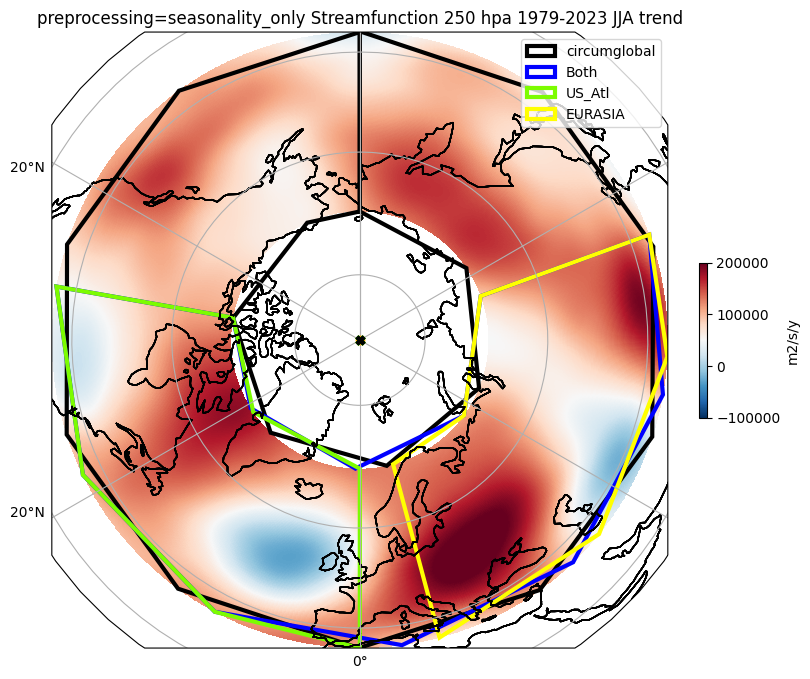

In [12]:
# plot polar projection LambertConformal(central_longitude=-96.0

data=daJJA_1979_None_trend
year_str="1979-2023"

######
shading = 'flat'
vmin, vmax = -100000, 200000
cmap = 'RdBu_r'
fig, ax = plt.subplots(figsize = (20,8), subplot_kw={'projection':ccrs.Orthographic(central_longitude=0,central_latitude=90)}) #subplot_kw={'projection':ccrs.LambertConformal()}
im = ax.pcolormesh(data.longitude, data.latitude, data.values[:-1,:-1], transform=ccrs.PlateCarree(),
                        shading = shading, cmap = cmap, vmin = vmin, vmax = vmax)

for lat, lon in sf_extreme_locs:
    marker = 'o' if sf_extreme_positive[(lat,lon)] else 'X'
    ax.scatter(lon, lat, color = geoclass[(lat,lon)]['color'],zorder = 10, marker = marker)
    ax.coastlines()

for subdomain, coords in subdomains_.items():
    print(subdomain, coords)
    ax.add_patch(mpatches.Rectangle(xy=[coords[2], coords[0]], width=coords[3]-coords[2], height=coords[1]-coords[0],
                                        facecolor='none', edgecolor=colors_dict[subdomain], linewidth=3,
                                        transform=ccrs.PlateCarree(), label=subdomain))
    
plt.legend()    
ax.set_title(f'preprocessing={preprocessing} {longname} {year_str} JJA trend')
ax.gridlines(draw_labels = ['left','bottom'])
fig.colorbar(im, ax=ax, fraction=0.005, pad=0.02, label=f"{unit}/y")
plt.show()

#  to actually run :

In [16]:
region = "EURASIA" #or EURASIA / "US_Atl"
threshold_cov = 0.5
lat_weighting = True
Sign_masked= True
mask_above_80=True

###
folder = "ERA5_CMIP6_SST_Pattern_Matches/"
filename_datacovars = f"{folder}covars_SSTs_ERA5andCMIP6_positive_matches_{region}_{threshold_cov}_latweighted{lat_weighting}_signmask{Sign_masked}_80masked{mask_above_80}_newTtest.csv"
filename_datacounts = f"{folder}counts_SSTs_ERA5andCMIP6_positive_matches_{region}_{threshold_cov}_latweighted{lat_weighting}_signmask{Sign_masked}_80masked{mask_above_80}_newTtest.csv"

load_data = os.path.isfile(f"{path_data}/{filename_datacovars}") #does this file exist?

print(f"Load data is {load_data}")

if load_data:
    data_covars = pd.read_csv(f"{path_data}/{filename_datacovars}", index_col=0)
    data_counts = pd.read_csv(f"{path_data}/{filename_datacounts}", index_col=0)
    
if not load_data:
    data_covars, data_counts = get_covariances(region, threshold_cov, models, 
                                               daJJA_removed_seasonality, daJJA_1979_None_trend,
                                               lat_weight=lat_weighting, Sign_masked=Sign_masked)
    data_covars.to_csv(f"{path_data}/{filename_datacovars}")
    data_counts.to_csv(f"{path_data}/{filename_datacounts}")

Load data is True


In [17]:
# to plot 

In [18]:
## GETTING SOME COLORS AND MARKERS FOR THE PLOTTING 

from matplotlib import colormaps
colors = []
for i in np.arange(0,1,1/19):
    colors.append(colormaps.get_cmap('tab20')(i))

markers = {'.': 'point',
 'o': 'circle',
 'v': 'triangle_down',
 '^': 'triangle_up',
 '<': 'triangle_left',
 '>': 'triangle_right',
 'x': 'tri_down',
 '1': ".",          
 '2': 'tri_up',
 '3': 'tri_left',
 '4': 'tri_right',
 '8': 'octagon',
 's': 'square',
 'p': 'pentagon',
 '*': 'star',
 'h': 'hexagon1',
 'H': 'hexagon2',
 '+': 'plus',
 'x': 'x',
 'D': 'diamond'}.keys()

marker_dict = {}
color_dict = {}
for i, model in enumerate(data_covars["model_name"]):
    print(i, model)
    marker_dict[model]=list(markers)[i]
    color_dict[model]=colors[i]

0 MIROC6
1 MPI-ESM-1-2-HAM
2 MPI-ESM1-2-HR
3 MPI-ESM1-2-LR
4 MRI-ESM2-0
5 NorESM2-LM
6 NorESM2-MM
7 GFDL-CM4
8 EC-Earth3-Veg-LR
9 EC-Earth3-Veg
10 EC-Earth3
11 CanESM5
12 CNRM-ESM2-1
13 CNRM-CM6-1
14 CMCC-CM2-SR5
15 CESM2-WACCM
16 BCC-CSM2-MR
17 AWI-ESM-1-1-LR
18 ACCESS-CM2


/scratch/1277885/ipykernel_2845186/1532217866.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter("Week -1", data_covars["week1"][i], c=color_dict[model], marker=marker_dict[model])
/scratch/1277885/ipykernel_2845186/1532217866.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter("Week -2", data_covars["week2"][i], c=color_dict[model], marker=marker_dict[model])
/scratch/1277885/ipykernel_2845186/15322

Text(0.5, 1.0, 'SST pattern correlation for EURASIA and ERA5 SSTs \n threshold=0.5, LatWeight=True, \n Sign_masked=True, 80Masked=True \n')

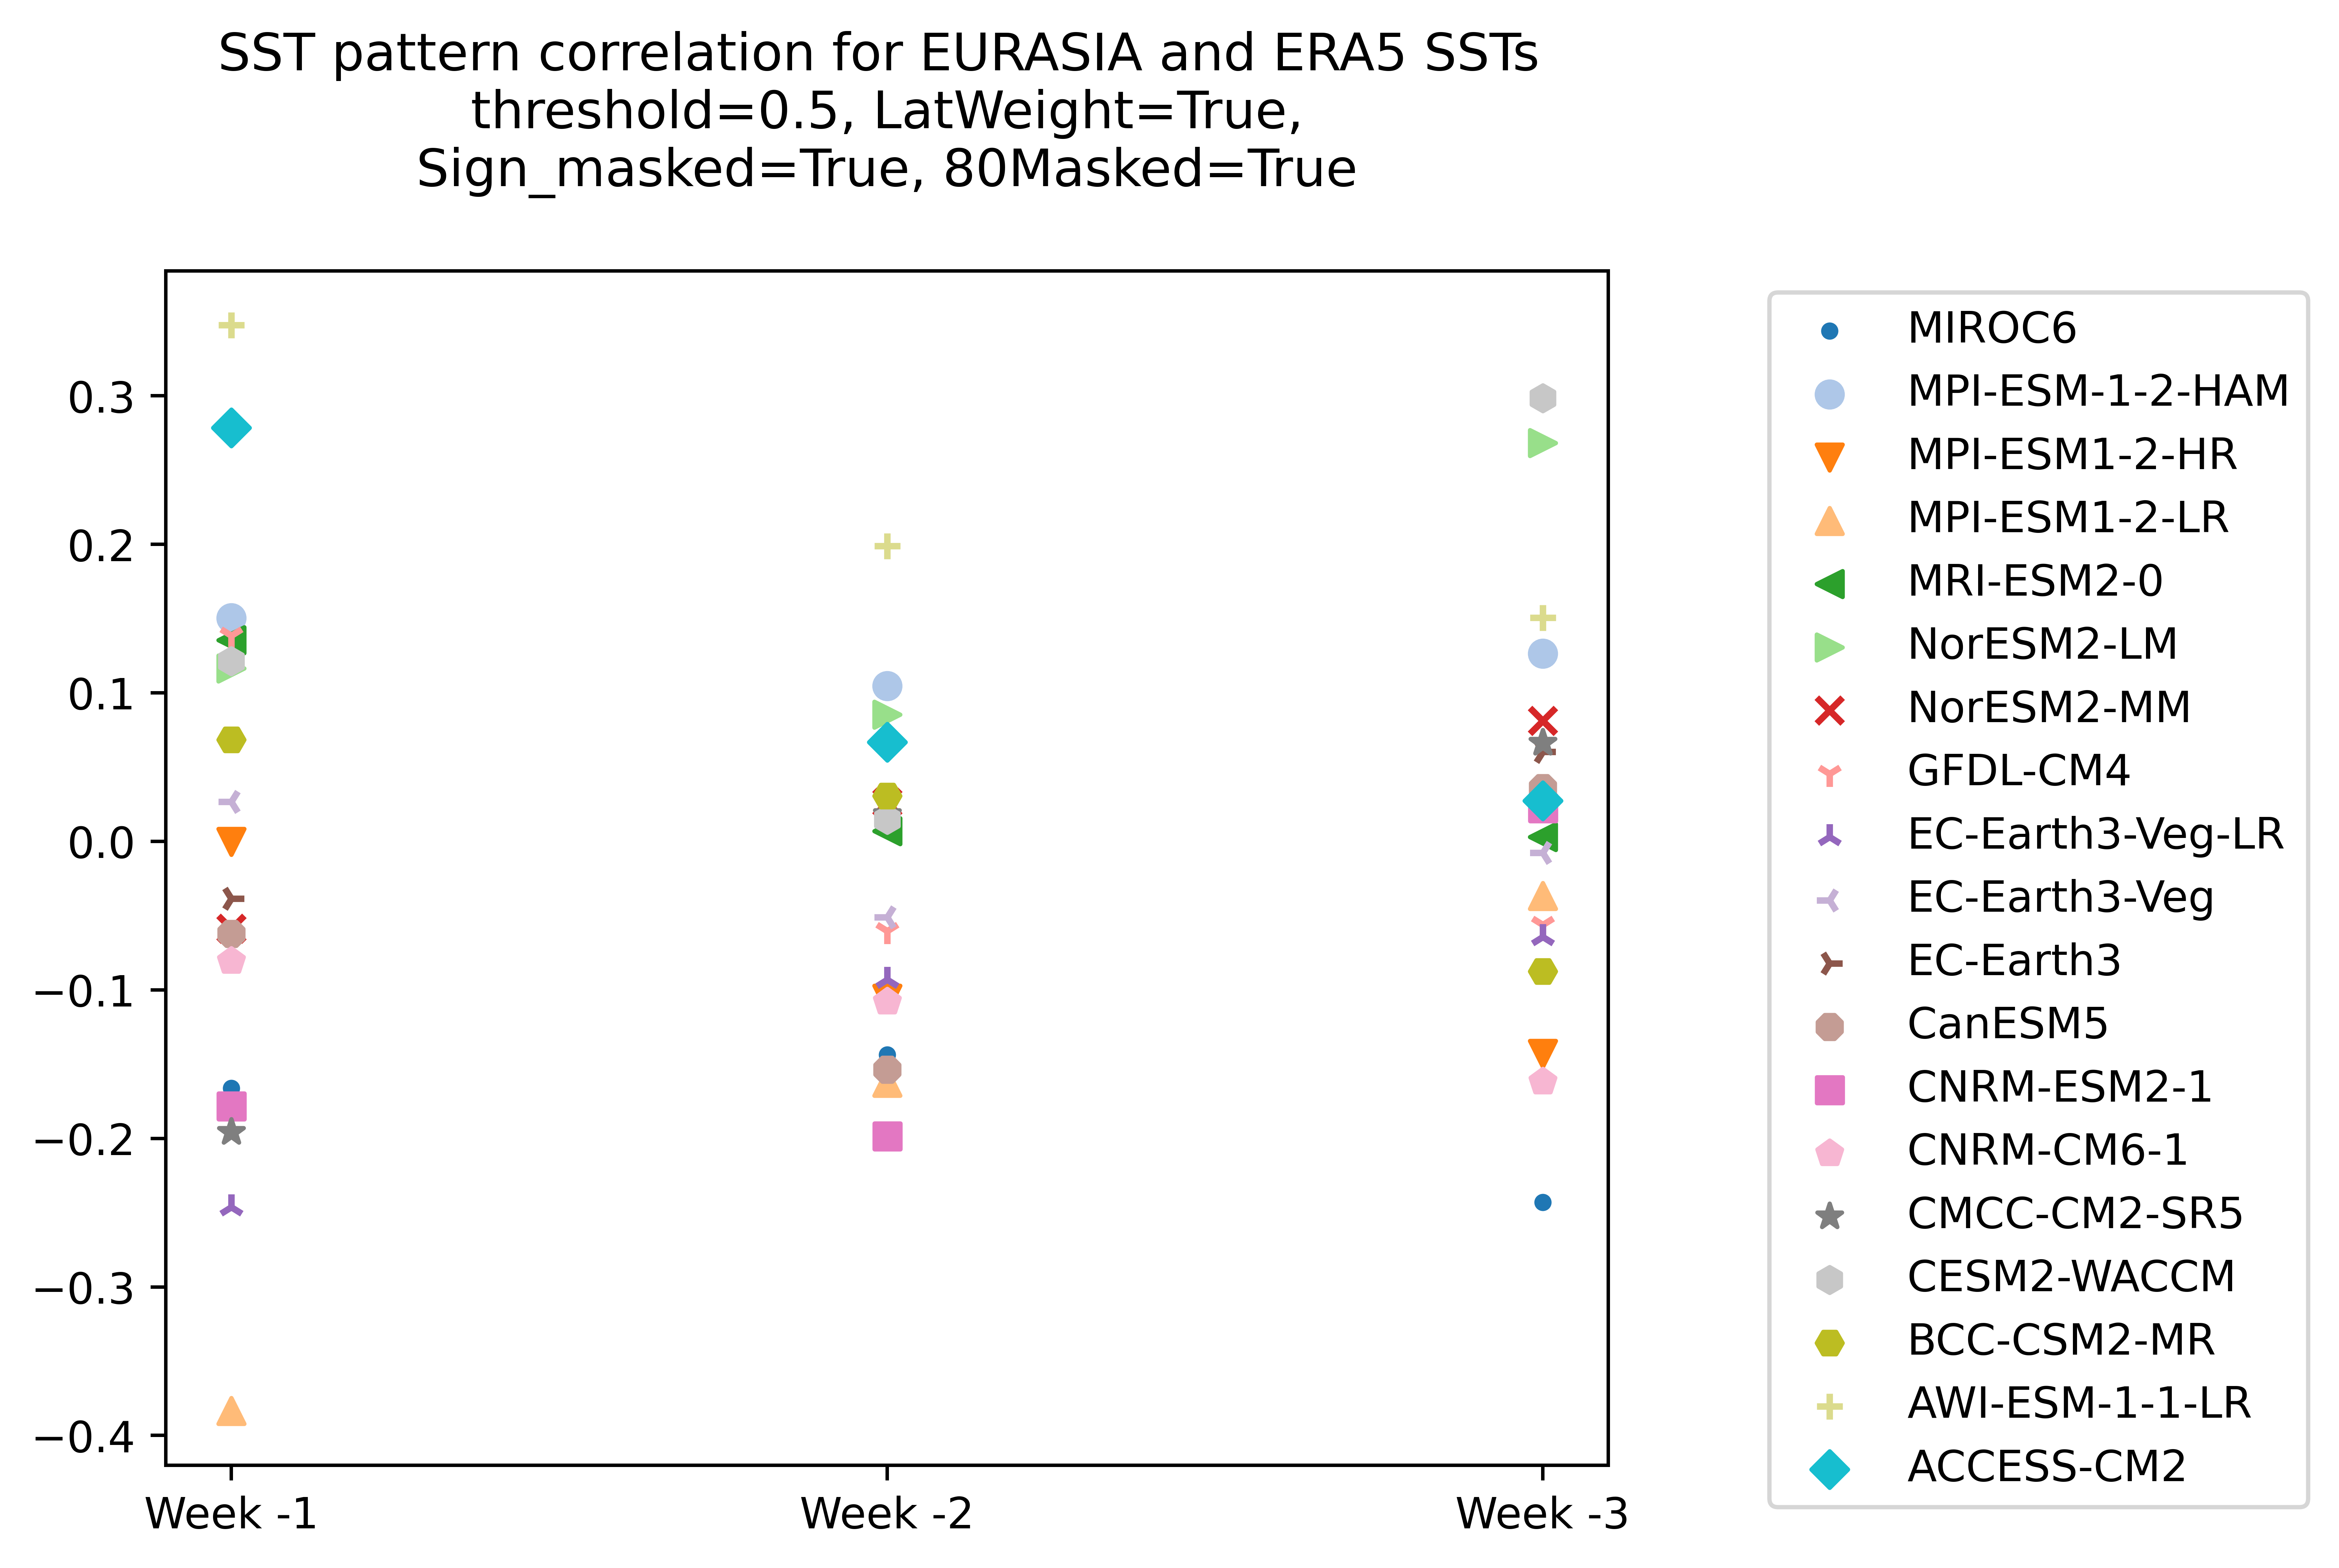

In [19]:
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["figure.dpi"]=900

for i, model in enumerate(data_covars["model_name"]):
    plt.scatter("Week -1", data_covars["week1"][i], c=color_dict[model], marker=marker_dict[model])
    plt.scatter("Week -2", data_covars["week2"][i], c=color_dict[model], marker=marker_dict[model])
    plt.scatter("Week -3", data_covars["week3"][i], c=color_dict[model], marker=marker_dict[model], label=model)
    
plt.legend(loc="upper right", bbox_to_anchor=(1.5,1))
# plt.ylim(-0.15, 0.15)
plt.title(f"SST pattern correlation for {region} and ERA5 SSTs \n threshold={threshold_cov}, LatWeight={lat_weighting}, \n Sign_masked={Sign_masked}, 80Masked={mask_above_80} \n")


# Old stuff which is moved to composites.py

## get sst patterns van ERA5 

In [8]:
from typing import Union


def covariance_timeseries3(pattern: Union[xr.DataArray, np.ndarray], array: Union[xr.DataArray, np.ndarray], latitude_weighting: bool = True, normalize: bool = False) -> Union[xr.DataArray, np.ndarray]:
    """
    calculates covariance timeseries using onelag_cov, for a given pattern.
    IN: var_pattern: array of (lat,lon) - pattern you want to check covariance with
    var_array: array of (time, lat, lon) - for which you want to get a timeseries with the covariance
    OUT: out_series: array of (time,) - with covariance for each timestep
    weighting as in: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Weighted_correlation_coefficient
    normalization means that you get a correlation value
    """
    # Flattening, and numpy from here on, reconstruction later
    if isinstance(pattern, xr.DataArray): # Stacked will become the last fimension
        pattern = pattern.stack({'latlon':['latitude','longitude']}) 
        array = array.stack({'latlon':['latitude','longitude']}) 
        original_coords = array.coords 
        pattern = pattern.values
        array = array.values
        reconstruct = True
    else:
        pattern = pattern.flatten()
        array = array.reshape((array.shape[0], (array.shape[1] * array.shape[2])))
        reconstruct = False
    if latitude_weighting: # array should be an xr.DataArray
        assert reconstruct, 'lat weighting only possible with access to coordinates, supply xr.DataArray'
        weights = np.cos(np.deg2rad(original_coords['latlon'].latitude.values))
    else:
        weights = np.ones_like(pattern) # Equal weight
    weights = weights/weights.sum() # Normalization, such that summing to one
    spatial_array_mean = np.nansum(weights[np.newaxis,:] * array, axis = -1) # shape (time,)
    spatial_pattern_mean = np.nansum(weights*pattern) # just a number
    array_diff = array - spatial_array_mean[:,np.newaxis] # Broadcasting to all gridcells
    pattern_diff = pattern - spatial_pattern_mean
    covariance = np.nansum(weights[np.newaxis,:] * (array_diff * pattern_diff[np.newaxis,:]), axis = -1)
    if normalize:
        variance_array = np.nansum(weights[np.newaxis,:] * (array_diff * array_diff), axis = -1)
        variance_pattern = np.nansum(weights * (pattern_diff * pattern_diff))
        covariance = covariance / np.sqrt(variance_array*variance_pattern)

    if reconstruct:
        reconstruct_dims = list(original_coords.dims)
        reconstruct_dims.remove('latlon')
        return covariance[0]
        
    return covariance

In [9]:
def _significance_t_test(subset, data_without_subset):
    from scipy.stats import ttest_ind

    '''computes two sided t-test, Welch's
    with nan_policy = omit
    a
    returns t and p values
    
    subset= composites
    data is data without subset
    '''
    
    results = ttest_ind(subset, data_without_subset, 
                        equal_var=False, nan_policy="omit")
    
    return results[0], results[1]

In [10]:
def plot_this_VAR_pattern(var_to_plot, VAR_aggregated_data, 
                          VAR_aggregated_positives, VAR_aggregated_positives_mean,
                          detrending_var, detrending_how_var, 
                          week_lag, region, model="ERA5",
                          lower_year=1940, upper_year=2019,
                          sign=True, covar_threshold=0.5):
#     sign = True

    if model == "ERA5":
        filename=f"{model}_{var_to_plot}_{week_lag}_{region}_{covar_threshold}_sign{sign}"
        fname_figure = f"/scistor/ivm/the410/WAVE5/figures/composites_ERA5/{filename}.png"
    else:
        filename=f"{model}_{var_to_plot}_{week_lag}_{region}_{covar_threshold}_sign{sign}"
        fname_figure = f"/scistor/ivm/the410/WAVE5/figures/composites_CMIP6/{filename}.png"
        
    if os.path.isfile(fname_figure): #check if plot already exists
        #figure already exists
        print("SST composite figure already exists")
    else:
        print("SST composite figure doesn't exists yeat")

        ## FOR VARS T2M, SST, OLR
        if var_to_plot in ["T2M", "sst", "OLR"]:
            data = VAR_aggregated_positives_mean
            lons = VAR_aggregated_data.longitude
            lats = VAR_aggregated_data.latitude

            sst_title = f"Weekly detrended={detrending_var} {detrending_how_var}, week lag={week_lag}, T-Test={sign}"

            if var_to_plot == "T2M" :
                vmin, vmax = -2, 2
            elif var_to_plot == "sst":
                vmin, vmax = -1, 1
            elif var_to_plot == "OLR":
                vmin, vmax = -60000, 60000

            if sign:
                t, p = _significance_t_test(VAR_aggregated_positives, VAR_aggregated_data)
                data = np.where(p <= 0.05, VAR_aggregated_positives_mean, np.NaN)


        title=f"{model} {var_to_plot} {lower_year}-{upper_year} {region} \n {sst_title} \n with JJA trend 1979-2023 \n and covar_tresh={covar_threshold}"



        ######
        shading = 'flat'

        cmap = 'RdBu_r'
        fig, ax = plt.subplots(figsize = (20,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
        im = ax.pcolormesh(lons, lats, data[:-1,:-1], transform = ccrs.PlateCarree(),
                                shading = shading, cmap = cmap, vmin=vmin, vmax=vmax)
        # for lat, lon in sf_extreme_locs:
        #     marker = 'o' if sf_extreme_positive[(lat,lon)] else 'X'
        #     ax.scatter(lon, lat, color = geoclass[(lat,lon)]['color'],zorder = 10, marker = marker)

        coords = subdomains[region]
        color=colors_dict[region]
        ax.add_patch(mpatches.Rectangle(xy=[coords[2], coords[0]], width=coords[3]-coords[2], height=coords[1]-coords[0],
                                        facecolor='none', edgecolor=color, linewidth=4,
                                        transform=ccrs.PlateCarree()))

        ax.coastlines()
        ax.set_title(title)
        ax.gridlines(draw_labels = ['left','bottom'])
        fig.colorbar(im, ax=ax, fraction=0.005, pad=0.02, label=f"")
        plt.show()
        fig.savefig(fname_figure)

In [9]:
def get_sst_pattern_ERA5(region, data_removed_seasonality, trend_pattern,
                        covar_treshold=0.5, detrending_sst=False, 
                        lower_year = 1950, upper_year = 2014, Sign_masked=True):
    '''
    Calculates the covariances for a certain region of the streamfunction with the 
    ERA5 trend pattern from 1979-2023. Takes those indices where covar_threshold is exceeded.
    Then takes those SST weeks, with different time lags (1,2,3). Creates composites, plots those. 
    Returns the composite pattern for the different timelags. 
    If Sign_masked=True, it uses the p values
    to mask out the non-significant areas, and returns that composite AND the pvals for each timelag. 
    
    out is a dictionary with for each time lag a tuple with the sst_pattern and the number of positive matches
    pvals is a dictionary with pvals, if Sign_masked=False, will be empty
    '''
    
    
    ## set constants
    trend_years = "1979-2023"
    anomalies = True
    time_aggr_covars = 'weekly'
    
    if detrending_sst == True:
        detrending_how_sst = "Global"
#         lower_year = 1950 #because that is the timeperiod of the detrended ssts
#         upper_year = 2021

    elif detrending_sst == False:
        remove_seasonality_sst = True
        detrending_how_sst = "None"
    
    ##
    print(region, trend_years)
    print(subdomains[region])
    print(f"Anomalies is {anomalies}")

    #get values for streamfunction
    subset_region = spatial_subset(data_removed_seasonality, subdomain=region)
    #calculate anomalies per gridpoint
    if anomalies:
        subset_region_spatial_mean = subset_region.mean(axis=0)
        subset_region_anoms = subset_region - subset_region_spatial_mean
        subset_region = subset_region_anoms

    if trend_years == "1979-2023":
        subset_region_trend = spatial_subset(trend_pattern, subdomain=region)
        subset_region_covars = covariance_timeseries2(subset_region_trend, subset_region, normalize=True)

    if time_aggr_covars == "weekly":
        # To slice the years to be able to regress on SSTS 
        subset_region_covars_weekly_1950_2021 = subset_region_covars.sel(time=subset_region_covars.time.dt.year>=lower_year)
        subset_region_covars_weekly_1950_2021 = subset_region_covars_weekly_1950_2021.sel(time=subset_region_covars_weekly_1950_2021.time.dt.year<=upper_year)

        subset_region_covars_aggregated = subset_region_covars_weekly_1950_2021.resample(time="1W").mean()
        subset_region_aggregated = subset_region.resample(time="1W").mean(dim="time")
        
    #### get SST values
        
    var_to_plot = "sst"
    print(f"variable of interest is {var_to_plot}")
 
    time_aggr_ssts = 'weekly' 

    if not detrending_sst:
        if os.path.isfile(f"{path_data}/deseasonalised_weekly_SST_era5_NHExt_0.25degr_{lower_year}_{upper_year}_JJA.nc"): #check if file already exists
            print("SST deseasonalized already exists so just loading data")
            SSTs_aggregated = xr.open_dataset(f"{path_data}/deseasonalised_weekly_SST_era5_NHExt_0.25degr_{lower_year}_{upper_year}_JJA.nc")["sst"]
        else:
            SSTs = xr.open_dataset(f"{path_data}/SST_era5_NHExt_0.25degr_19400101-20240229_JJA.nc")
            SSTs = SSTs["sst"].sel(time=SSTs.time.dt.year<=upper_year) #because last years are corrupted still... 
            SSTs = SSTs.sel(time=SSTs.time.dt.year>=lower_year)
            SSTs_weekly = SSTs.resample(time="1W").mean(skipna=True)
            if remove_seasonality_sst:
                sst_weekly_ = SSTs_weekly.sel(time=SSTs_weekly.time.dt.month.isin([6,7,8])) #to just select JJA
                ## calculate weekly mean, for each gridpoint 
                SSTs_weekly_mean = SSTs_weekly.groupby(SSTs_weekly.time.dt.week).mean(dim="time")
                #to resample to just the summer
                SSTs_weekly_mean = SSTs_weekly_mean.sel(week=SSTs_weekly_mean.week.isin([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,35]) )
                #deseasanlise by removing the weekly mean
                SSTs_aggregated = sst_weekly_.groupby(sst_weekly_.time.dt.week) - SSTs_weekly_mean
                SSTs_aggregated.to_netcdf(f"{path_data}/deseasonalised_weekly_SST_era5_NHExt_0.25degr_{lower_year}_{upper_year}_JJA.nc")


    if detrending_sst:
        print("detrending is True")
        print(detrending_how_sst)
        if detrending_how_sst == "Global":
            '''lowess fit is done on global mean SST values, '''
            #SSTs_weekly = xr.load_dataset("/scistor/ivm/the410/WAVE5/detrended_GlobalTrend_weekly_ssts_nhplus_june2sept.nc")
            '''then anomalies are calculated gridpoint wise'''
            SSTs_aggregated = xr.load_dataset("/scistor/ivm/the410/WAVE5/detrended_GlobalTrend_weekly_ssts_anoms_nhplus_june2sept.nc").astype("float32")
            
    if var_to_plot == "sst":
        time_aggr_var = time_aggr_ssts
#         data_var = SSTs_aggregated
        detrending_var = detrending_sst
        detrending_how_var = detrending_how_sst

    ###
    if time_aggr_covars == "weekly" and time_aggr_var == 'weekly':
        time_aggr = 'weekly'
    else:
        print("time aggregations are not alligned")


#     data_covars = subset_region_covars_aggregated

    ## SET DATA AND SELECT JJA ONLY     
    data_covars = subset_region_covars_aggregated.sel(time=subset_region_covars_aggregated.time.dt.month.isin([6,7,8]))
    data_var_aggr = SSTs_aggregated.sel(time=SSTs_aggregated.time.dt.month.isin([6,7,8]))
    
    ## 
    indices_bool = np.where(data_covars>covar_treshold, 1, 0) #get boolean timeseries
    time_indices_treshold_excedance = data_covars.time[np.where(data_covars>covar_treshold)] #get time indices
    indices_treshold_excedance = np.where(data_covars>covar_treshold)[0] #get raw indices

    out = {}
    pvals = {}
    
    ## TO FILTER FOR DIFFERENT TIME LAGS 
    for week_lag in [1,2,3]:
        indices_filtered_with_lag = []
        reverse_indices_with_lag = []
        for i in indices_treshold_excedance:
            #print(i, i%13)
            if i%13 >= abs(week_lag):
                #print("don't skip")
                indices_filtered_with_lag.append(i-week_lag)
                reverse_indices_with_lag.append(data_covars.time[i-week_lag].values) #get the corresponding time stamp
            else:
                #print("skip")
                continue
        if detrending_sst:
            VAR_aggregated_positives = data_var_aggr.to_array().values[0][indices_filtered_with_lag] #get Var of weeks where threshold is exceeded
        else:
            VAR_aggregated_positives = data_var_aggr.values[indices_filtered_with_lag] #get Var of weeks where threshold is exceeded
        VAR_aggregated_positives_mean = VAR_aggregated_positives.mean(axis=0)
        #make xarray of VAR_aggregated_positives_mean
        
        #to get the all the data without the subset(composite)
        data_var_aggr_subset = data_var_aggr.drop(reverse_indices_with_lag, dim="time") #get the data without positive matches 
       
        
        if Sign_masked:
            ## get pvals for this timelag 
            t, p = _significance_t_test(VAR_aggregated_positives, data_var_aggr_subset)
            pvals[week_lag]=p
            VAR_aggregated_positives_mean = np.where(p <= 0.05, VAR_aggregated_positives_mean, np.NaN)
        
        out_array = np.zeros((1, 521, 1440))
        out_array[0,:,:]=VAR_aggregated_positives_mean
        xr_out = xr.DataArray(
                data=out_array,
                dims=["time", "latitude", "longitude"],
                coords=dict(
                    time=[0],
                    longitude=data_var_aggr.longitude,
                    latitude=data_var_aggr.latitude),
                attrs=dict(
                    description="SST composite anomalies",
                    units="degC"))
        out[week_lag]=[xr_out, len(indices_filtered_with_lag)] #returning also the nr of positive matches
    
        ##
#         # to plot: #--> see other notebook
#         plot_this_VAR_pattern(var_to_plot, data_var_aggr, 
#                           VAR_aggregated_positives, VAR_aggregated_positives_mean,
#                           detrending_var, detrending_how_var, 
#                           week_lag, region, model="ERA5",
#                           lower_year=lower_year, upper_year=upper_year,
#                           sign=True, covar_threshold=covar_treshold)
#         plot_this_VAR_pattern(var_to_plot, data_var_aggr, 
#                           VAR_aggregated_positives, VAR_aggregated_positives_mean,
#                           detrending_var, detrending_how_var, 
#                           week_lag, region, model="ERA5",
#                           lower_year=lower_year, upper_year=upper_year,
#                           sign=False, covar_threshold=covar_treshold)
    
    return out, pvals

In [9]:
def get_sst_pattern_CMIP6(model, region, trend_pattern, 
                          covar_threshold=0.5, 
                          detrending_sst=False, lower_year = 1950, upper_year = 2014, 
                          Sign_masked=False, pvals_era={}):
    '''
    Takes a CMIP6 model, calculates the covariances of the streamfunction with the 
    ERA5 trend pattern from 1979-2023, for specified region. Takes those indices where covar_threshold is exceeded.
    Then takes those SST weeks, with different time lags (1,2,3). Creates composites, plots those. 
    Returns the composite pattern for the different timelags. 
    If Sign_masked=True, it uses the p values of the ERA5 SST pattern for the same period (lower_year, upper_year)
    to mask out the non-significant areas from ERA5.
    
    out is a dictionary with for each time lag a tuple with the sst_pattern and the number of positive matches
    '''
    
    
    ##set variables 
    trend_years = "1979-2023"
    anomalies = True
    time_aggr_covars = 'weekly'
    
    ##
    print(region, trend_years)
    print(subdomains[region])
    print(f"Anomalies is {anomalies}")
    print(model)
    
    var_to_plot = "sst"
    print(f"variable of interest is {var_to_plot}")
    time_aggr_ssts = 'weekly' 
    
    if detrending_sst == True:
        detrending_how_sst = "Global"

    elif detrending_sst == False:
        remove_seasonality_sst = True
        detrending_how_sst = "None"

    ##
    ## get STREAM250 data fro model
    filename = f"regridded_{model}_stream250_1950_2014_JJA_midlats.nc"
    data = xr.open_dataset(f"{path_data}/CMIP6/250/{filename}")["stream"]
    if model in ["CESM2-WACCM", "NorESM2-LM", "NorESM2-MM", "GFDL-CM4", "CanESM5", "CMCC-CM2-SR5", "CESM2-WACCM", "BCC-CSM2-MR",]:
        print("converting calendar")
        data = data.convert_calendar(calendar='standard')
    #remove seasonality
    data_removed_seasonality = remove_spatmean_variability(data, how=preprocessing)
    data_removed_seasonality = data_removed_seasonality.sel(time=data_removed_seasonality.time.dt.year>=lower_year)
 
    #LOAD SST DATA
    if detrending_sst:
        filename = f"detrended_anoms_GlobalTrend_weekly_sst_{model}_MJJA.nc"
        SST_model = xr.open_dataset(f"{path_data}/CMIP6/SST/{filename}")["sst_anoms"]
        data_var_aggr = SST_model.sel(time=SST_model.time.dt.month.isin([6,7,8]))
    if not detrending_sst:
        filename = f"regridded_nhplus_sst_1950_2014_{model}_MJJA.nc"
        fname = f"{path_data}/CMIP6/SST/deseasonalised_weekly_{lower_year}_{upper_year}_{filename}"
        
        if os.path.isfile(fname): #check if file already exists
            print("SST deseasonalized already exists so just loading data")
            data_var_aggr = xr.open_dataset(fname)["tos"]
        else:
            print("SSTs have to be deseasonalized still")
            SSTs = xr.open_dataset(f"{path_data}/CMIP6/SST/{filename}")["tos"]
            if model in ["CESM2-WACCM", "NorESM2-LM", "NorESM2-MM", "GFDL-CM4", "CanESM5", "CMCC-CM2-SR5", "CESM2-WACCM", "BCC-CSM2-MR"]:
                print("converting calendar")
                SSTs = SSTs.convert_calendar(calendar='standard')
            ## still deseasonalize
            SSTs = SSTs.sel(time=SSTs.time.dt.year>=lower_year)
            SSTs = SSTs.sel(time=SSTs.time.dt.year<=upper_year)#because last years are corrupted still... 
            SSTs_weekly = SSTs.resample(time="1W").mean(skipna=True)
            if remove_seasonality_sst:
                sst_weekly_ = SSTs_weekly.sel(time=SSTs_weekly.time.dt.month.isin([6,7,8])) #to just select JJA
                ## calculate weekly mean, for each gridpoint 
                SSTs_weekly_mean = SSTs_weekly.groupby(SSTs_weekly.time.dt.week).mean(dim="time")
                #to resample to just the summer
                SSTs_weekly_mean = SSTs_weekly_mean.sel(week=SSTs_weekly_mean.week.isin([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,35]) )
                #deseasanlise by removing the weekly mean
                data_var_aggr = sst_weekly_.groupby(sst_weekly_.time.dt.week) - SSTs_weekly_mean
                data_var_aggr.to_netcdf(f"{path_data}/CMIP6/SST/deseasonalised_weekly_{lower_year}_{upper_year}_{filename}")
    


    #get values from CMIP6
    subset_region = spatial_subset(data_removed_seasonality, subdomain=region)

    #calculate anomalies per gridpoint
    if anomalies:
        subset_region_climatology = subset_region.mean(dim="time")
        subset_region_anoms = subset_region - subset_region_climatology
        subset_region = subset_region_anoms

    ## CALCULATE COVARIANCE WITH ERA5 TREND 
    if trend_years == "1979-2023":
        era5_trend = spatial_subset(trend_pattern, subdomain=region) #FROM ERA5
        subset_region_covars = covariance_timeseries2(era5_trend, subset_region, normalize=True)

    if time_aggr_covars == "weekly":
        subset_region_covars_aggregated = subset_region_covars.resample(time="1W").mean(dim="time")
        subset_region_aggregated = subset_region.resample(time="1W").mean(dim="time")
        
    data_covars = subset_region_covars_aggregated.sel(time=subset_region_covars_aggregated.time.dt.month.isin([6,7,8]))
#     data_covars = subset_region_covars_aggregated.sel(time=subset_region_covars_aggregated.time.dt.week.isin([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,35]))
    
    
    ## plot deze covars en opslaan
    fname_figure=f"{model}_covariances_withERA5pattern_{region}_{covar_threshold}"
    if not os.path.isfile(f"/scistor/ivm/the410/WAVE5/figures/composites_CMIP6/{fname_figure}.png"): #check if plot already exists
        print("covar plot doesn't exists yet")
        data_covars.plot()
        plt.plot(data_covars.time, np.full(data_covars.shape, covar_threshold), label="threshold")
        plt.title(f"{time_aggr_covars}-mean covariances on JJA trend pattern {region} \n {model} and ERA5 \n preprocessing={preprocessing}")
        plt.tight_layout()
        plt.savefig(f"/scistor/ivm/the410/WAVE5/figures/composites_CMIP6/{fname_figure}.png")

    
    # get indices 
    indices_bool = np.where(data_covars>covar_threshold, 1, 0)[:,0] #get boolean timeseries
    time_indices_treshold_excedance = data_covars.time[indices_bool] #get time indices
    indices_treshold_excedance = np.where(data_covars>covar_threshold)[0] #get raw indices

    out = {}
    
    for week_lag in [1,2,3]:
        indices_filtered_with_lag = []
        for i in indices_treshold_excedance:
            #print(i, i%13)
            if i%13 >= abs(week_lag):
                #print("don't skip")
                indices_filtered_with_lag.append(i-week_lag)
            else:
                #print("skip")
                continue
        
#         print(data_var_aggr.time.dt.week)
#         print(data_covars.time.dt.week) #this has one year extra? why )
        
        
        VAR_aggregated_positives = data_var_aggr.values[indices_filtered_with_lag] #get Var of weeks where threshold is exceeded
        VAR_aggregated_positives_mean = VAR_aggregated_positives.mean(axis=0)
        
        ## Here create the p-val mask with ERA5 pvals, and then if Sign_masked=True, 
        #return that instead, also in ERA5         
        if Sign_masked:
            # Get pvals from era and use that for the mask 
            VAR_aggregated_positives_mean = np.where(pvals_era[week_lag] <= 0.05, VAR_aggregated_positives_mean, np.NaN)
        
        #make xarray of VAR_aggregated_positives_mean    
        out_array = np.zeros((1, 521, 1440))
        out_array[0,:,:]=VAR_aggregated_positives_mean
        xr_out = xr.DataArray(
                data=out_array,
                dims=["time", "latitude", "longitude"],
                coords=dict(
                    time=[0],
                    longitude=data_var_aggr.longitude,
                    latitude=data_var_aggr.latitude),
                attrs=dict(
                    description=f"SST composite anomalies, ERA5 sign mask={Sign_masked}",
                    units="degC"))
        out[week_lag]=[xr_out, len(indices_filtered_with_lag)] #returning also the nr of positive matches
    
#         ## to plot:
#         print("now plotting")
#         plot_this_VAR_pattern(var_to_plot, data_var_aggr, 
#                           VAR_aggregated_positives, VAR_aggregated_positives_mean,
#                           detrending_sst, detrending_how_sst, 
#                           week_lag, region, model=model,
#                           lower_year=lower_year, upper_year=upper_year,
#                           sign=True, covar_threshold=covar_threshold)
#         plot_this_VAR_pattern(var_to_plot, data_var_aggr, 
#                           VAR_aggregated_positives, VAR_aggregated_positives_mean,
#                           detrending_sst, detrending_how_sst, 
#                           week_lag, region, model=model,
#                           lower_year=lower_year, upper_year=upper_year,
#                           sign=False, covar_threshold=covar_threshold)
        
        
    return out

In [10]:
def get_covariances(region, threshold_cov, models, data_removed_seasonality, trend_pattern,
                    lat_weight=True, Sign_masked=False, mask_above_80=True):
    

        
    ##
    counts = []
    sst_patterns_era5, pvals_era = get_sst_pattern_ERA5(region, data_removed_seasonality, trend_pattern,
                                                 covar_treshold=threshold_cov,
                                                 Sign_masked=Sign_masked)# if Sign_masked=False, pvals_era is empty        
    
    if mask_above_80:
        for week in [1,2,3]:
            pvals_era[week][np.where(sst_patterns_era5[week][0].latitude>80), :] = 1 #set pvals above lat=80 to 1 
    
    count=["ERA5"]
    for week_lag in [1,2,3]:
        era5 =  sst_patterns_era5[week_lag][1] #the first is the data, the second the nr of postiive matches
        count.append(era5)    
    counts.append(count)
    
    model_ssts = {}
    for model in models: 
        if model == "CanESM5" or model == "AWI-ESM-1-1-LR":
            print("Model CanESM5/AWI-ESM-1-1-LR do momentarily not have the year 1950??")
            lower_year = 1951
        else:
            lower_year = 1950
        ## here load the data:
        model_ssts[model]= get_sst_pattern_CMIP6(model, region, trend_pattern,
                                                 lower_year=lower_year, covar_threshold=threshold_cov,
                                                 Sign_masked=Sign_masked, pvals_era=pvals_era)
    
    covariances = []

    for model in models:
        covs = [model]
        count = [model]
        cmip6 = np.zeros((1, 521, 1440))
        for week_lag in [1,2,3]:
            era5 =  sst_patterns_era5[week_lag][0] #the first is the data, the second the nr of postiive matches
            #cmip6[0,:,:] = model_ssts[model][week_lag][0]
            cmip6 = model_ssts[model][week_lag][0]
            covs_week_model = covariance_timeseries3(era5, cmip6, normalize=True, latitude_weighting=lat_weight)
            #print(covs_week_model) #for this week and this model 
            covs.append(covs_week_model[0])
            count.append(model_ssts[model][week_lag][1])
        covariances.append(covs)
        counts.append(count)

    region_dataframe = pd.DataFrame(covariances, columns=["model_name", "week1", "week2", "week3"])
    region_dataframe_counts = pd.DataFrame(counts, columns=["model_name", "week1_n", "week2_n", "week3_n"])

    return region_dataframe, region_dataframe_counts


In [19]:
ls /scistor/ivm/the410/WAVE5/CMIP6/SST/

deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_ACCESS-CM2_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_BCC-CSM2-MR_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_CESM2-WACCM_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_CMCC-CM2-SR5_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_CNRM-CM6-1_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_CNRM-ESM2-1_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_EC-Earth3_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_EC-Earth3-Veg-LR_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_EC-Earth3-Veg_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_GFDL-CM4_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_MIROC6_MJJA.nc
deseasonalised_weekly_1950_2014_regridded_nhplus_sst_1950_2014_MPI-ESM-1-2-HAM_MJJA.nc
dese

In [14]:
models = ['MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'GFDL-CM4',
 'EC-Earth3-Veg-LR',
 'EC-Earth3-Veg',
 'EC-Earth3',
 'CanESM5',
 'CNRM-ESM2-1',
 'CNRM-CM6-1',
 'CMCC-CM2-SR5',
 'CESM2-WACCM',
 'BCC-CSM2-MR',
 'AWI-ESM-1-1-LR',
 'ACCESS-CM2']

### TO DO 21st june

in get_sst_pattern_cmip6 function
1. Put option for not-detrended ssts, and for seasonality removal ---- 
        ERA5 DONE -- CMIP6 DONE
        
2. return also the number of matches for each model
DONE, alleen nog kijken wat ik hiermee doe... 

3. plot and savefig also the SST composite for each model, both for significance and non-significance
        ---- ERA5 DONE - CMIP6 DONE
4. plot the annual covariance timeseries for the CMIP6 models, (with lowess trend?)
DONE

5. add latitude weighting and/or t-test weighting options in cmip6 pattern matching ---- 
    5.1 for lat weighting, I need to return an xarray for both SST patterns instead of an numpy array, so we have the lat lon coordinates
   DONEE - still to check
   
    5.2 for t_test I need to return the p values for ERA5 (coming out of the plotting function)

---- Then redo all of this, for all the cmip6 models and the 2 different regions
\n
\n
\n
1. als het te lang duurt misschien ook de sst composites opslaan van de models/era5? 
\n
\n
\n
1. of dit in een python script gooien voor het cluster



### hieronder is de main cell om de covars te krijgen, als ik nieuwe t-test functie schrijf moet ik dit hieronder runnen

In [8]:
region = "EURASIA" #or EURASIA / "US_Atl"
threshold_cov = 0.5
lat_weighting = True
Sign_masked= True
mask_above_80=True

###
folder = "ERA5_CMIP6_SST_Pattern_Matches/"
filename_datacovars = f"{folder}covars_SSTs_ERA5andCMIP6_positive_matches_{region}_{threshold_cov}_latweighted{lat_weighting}_signmask{Sign_masked}_80masked{mask_above_80}_newTtest.csv"
filename_datacounts = f"{folder}counts_SSTs_ERA5andCMIP6_positive_matches_{region}_{threshold_cov}_latweighted{lat_weighting}_signmask{Sign_masked}_80masked{mask_above_80}_newTtest.csv"

load_data = os.path.isfile(f"{path_data}/{filename_datacovars}") #does this file exist?

print(f"Load data is {load_data}")

if load_data:
    data_covars = pd.read_csv(f"{path_data}/{filename_datacovars}", index_col=0)
    data_counts = pd.read_csv(f"{path_data}/{filename_datacounts}", index_col=0)
    
if not load_data:
    data_covars, data_counts = get_covariances(region, threshold_cov, models, 
                                               daJJA_removed_seasonality, daJJA_1979_None_trend,
                                               lat_weight=lat_weighting, Sign_masked=Sign_masked)
    data_covars.to_csv(f"{path_data}/{filename_datacovars}")
    data_counts.to_csv(f"{path_data}/{filename_datacounts}")

Load data is False
EURASIA 1979-2023
(35, 70, 15, 110)
Anomalies is True
variable of interest is sst
SST deseasonalized already exists so just loading data
EURASIA 1979-2023
(35, 70, 15, 110)
Anomalies is True
MIROC6
variable of interest is sst
SST deseasonalized already exists so just loading data
EURASIA 1979-2023
(35, 70, 15, 110)
Anomalies is True
MPI-ESM-1-2-HAM
variable of interest is sst


KeyboardInterrupt: 

In [19]:
data_covars

,model_name,week1,week2,week3
0,MIROC6,0.177436,0.056786,0.028465
1,MPI-ESM-1-2-HAM,0.102250,-0.029238,-0.103982
2,MPI-ESM1-2-HR,-0.040073,0.000275,-0.000291
3,MPI-ESM1-2-LR,0.036645,0.065509,0.108038
4,MRI-ESM2-0,0.149917,0.056799,-0.028584
5,NorESM2-LM,-0.106536,-0.127108,-0.208164
6,NorESM2-MM,-0.211665,-0.153698,-0.156031
7,GFDL-CM4,0.297428,0.263471,0.162939
8,EC-Earth3-Veg-LR,0.101965,0.030086,-0.004827
9,EC-Earth3-Veg,0.074407,-0.037273,-0.010568


In [20]:
data_counts

,model_name,week1_n,week2_n,week3_n
0,ERA5,23,21,20
1,MIROC6,22,21,20
2,MPI-ESM-1-2-HAM,34,29,25
3,MPI-ESM1-2-HR,27,26,24
4,MPI-ESM1-2-LR,22,19,18
5,MRI-ESM2-0,20,18,17
6,NorESM2-LM,44,40,35
7,NorESM2-MM,44,42,38
8,GFDL-CM4,20,19,19
9,EC-Earth3-Veg-LR,23,21,17


In [148]:
## HERE plotting the data... 

In [16]:
## GETTING SOME COLORS AND MARKERS FOR THE PLOTTING 

from matplotlib import colormaps
colors = []
for i in np.arange(0,1,1/19):
    colors.append(colormaps.get_cmap('tab20')(i))

markers = {'.': 'point',
 'o': 'circle',
 'v': 'triangle_down',
 '^': 'triangle_up',
 '<': 'triangle_left',
 '>': 'triangle_right',
 'x': 'tri_down',
 '1': ".",          
 '2': 'tri_up',
 '3': 'tri_left',
 '4': 'tri_right',
 '8': 'octagon',
 's': 'square',
 'p': 'pentagon',
 '*': 'star',
 'h': 'hexagon1',
 'H': 'hexagon2',
 '+': 'plus',
 'x': 'x',
 'D': 'diamond'}.keys()

marker_dict = {}
color_dict = {}
for i, model in enumerate(data_covars["model_name"]):
    print(i, model)
    marker_dict[model]=list(markers)[i]
    color_dict[model]=colors[i]

0 MIROC6
1 MPI-ESM-1-2-HAM
2 MPI-ESM1-2-HR
3 MPI-ESM1-2-LR
4 MRI-ESM2-0
5 NorESM2-LM
6 NorESM2-MM
7 GFDL-CM4
8 EC-Earth3-Veg-LR
9 EC-Earth3-Veg
10 EC-Earth3
11 CanESM5
12 CNRM-ESM2-1
13 CNRM-CM6-1
14 CMCC-CM2-SR5
15 CESM2-WACCM
16 BCC-CSM2-MR
17 AWI-ESM-1-1-LR
18 ACCESS-CM2


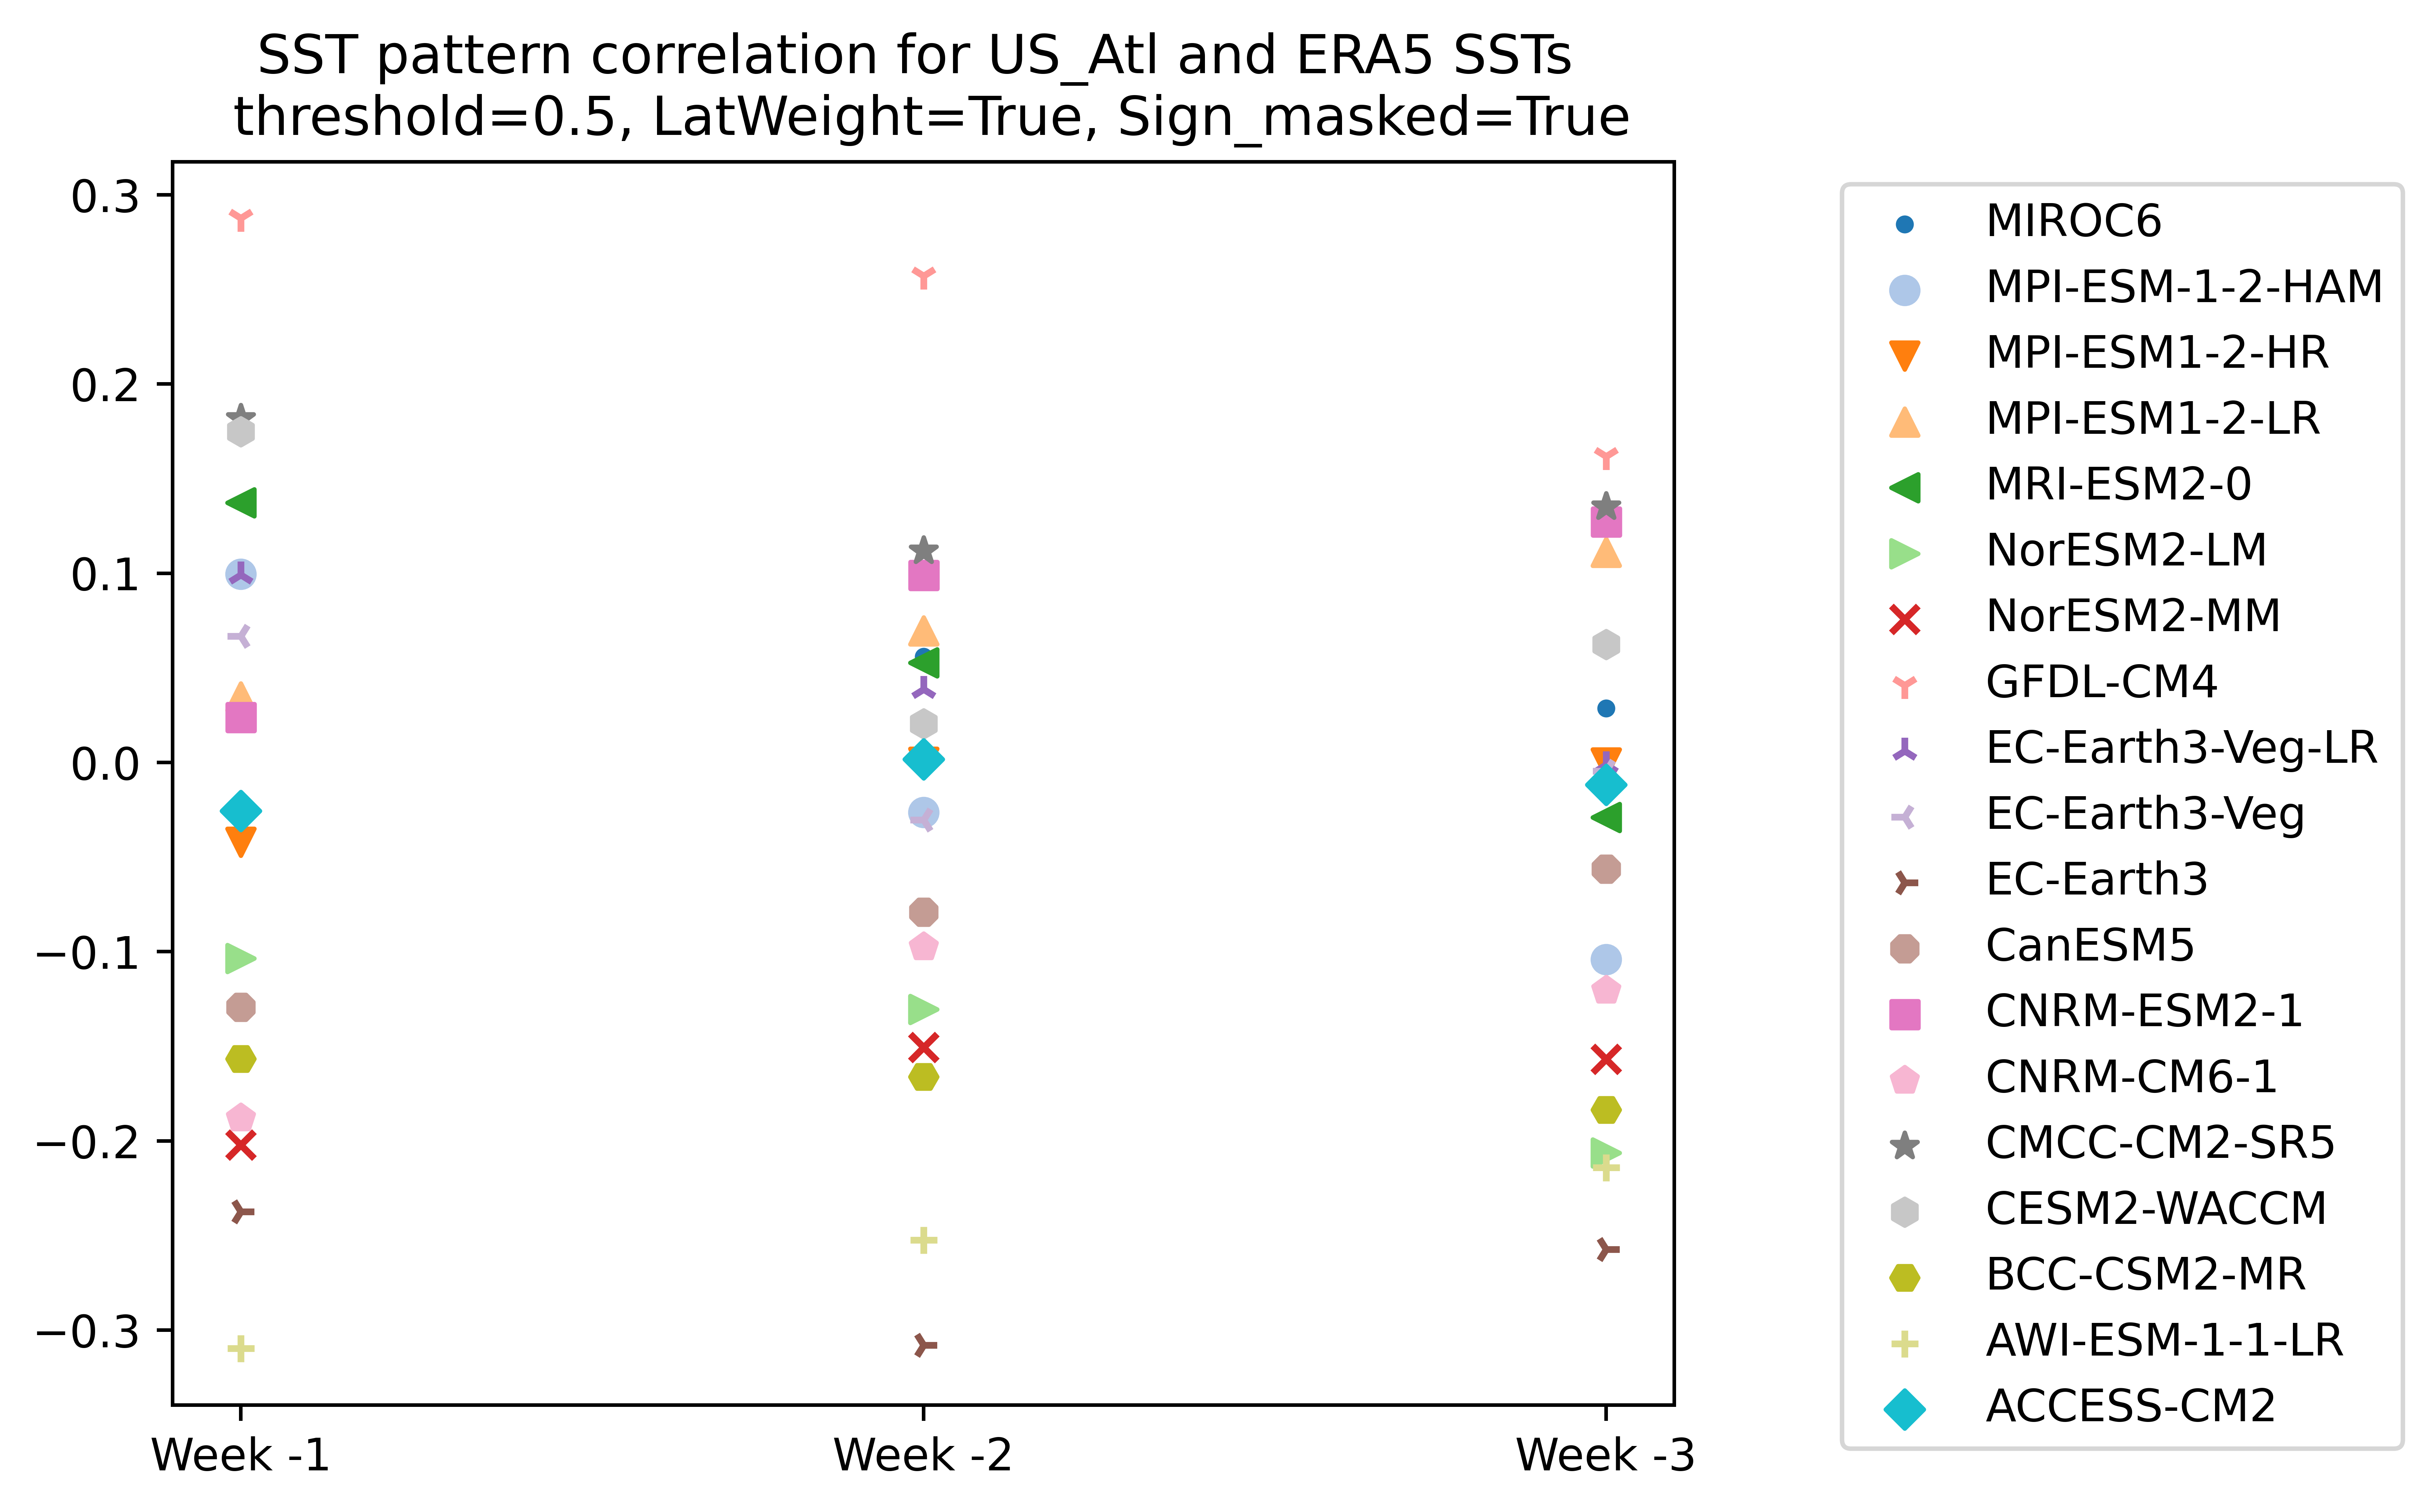

In [30]:

for i, model in enumerate(data_covars["model_name"]):
    plt.scatter("Week -1", data_covars["week1"][i], c=color_dict[model], marker=marker_dict[model])
    plt.scatter("Week -2", data_covars["week2"][i], c=color_dict[model], marker=marker_dict[model])
    plt.scatter("Week -3", data_covars["week3"][i], c=color_dict[model], marker=marker_dict[model], label=model)
    
plt.legend(loc="upper right", bbox_to_anchor=(1.5,1))
# plt.ylim(-0.15, 0.15)
plt.title(f"SST pattern correlation for {region} and ERA5 SSTs \n threshold={threshold_cov}, LatWeight={lat_weighting}, Sign_masked={Sign_masked}")
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["figure.dpi"]=900

In [ ]:
for i, model in enumerate(data_counts["model_name"]):
    if model == "ERA5":
        plt.scatter("Week -1", data_counts["week1_n"][i], c="black", marker="s")
        plt.scatter("Week -2", data_counts["week2_n"][i], c="black", marker="s")
        plt.scatter("Week -3", data_counts["week3_n"][i], c="black", marker="s", label=model)
    else:
        plt.scatter("Week -1", data_counts["week1_n"][i], c=color_dict[model], marker=marker_dict[model])
        plt.scatter("Week -2", data_counts["week2_n"][i], c=color_dict[model], marker=marker_dict[model])
        plt.scatter("Week -3", data_counts["week3_n"][i], c=color_dict[model], marker=marker_dict[model], label=model)
    
plt.legend(loc="upper right", bbox_to_anchor=(1.5,1))
# plt.ylim(-0.15, 0.15)
plt.title(f"Counts of Covar matches for {region} and ERA5 SSTs \n threshold={threshold_cov}, LatWeight={lat_weighting}, \n Sign_masked={Sign_masked}, 80masked={mask_above_80}")
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["figure.dpi"]=900